In [1]:
from __future__ import division, print_function
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import math
import numpy as np
import numpy.random
import scipy as sp
import scipy.stats

from ballot_comparison import findNmin_ballot_comparison_rates, ballot_comparison_pvalue
from hypergeometric import trihypergeometric_optim, simulate_ballot_polling_power
from fishers_combination import fisher_combined_pvalue, maximize_fisher_combined_pvalue, \
     bound_fisher_fun, calculate_lambda_range

# Example of a hybrid audit in a large election with an exact tie

The numbers in this example may not be realistic, but serve as an example of what would happen in a tie election.

There are two strata. One contains every CVR county and the other contains every no-CVR county.
There were 2 million ballots cast in the election, 1.9 million in the CVR stratum and 100,000 in the no-CVR stratum.

The reported vote margin between A and B is 22,000 votes, a "diluted margin" of just over $1\%$.


Candidate | Reported Stratum 1 |  Reported Stratum 2 | Reported total 
---|---|---|---
A | 960,000 | 51,000 | 1,011,000
B | 940,000 | 49,000 | 989,000
Ballots | 1,900,000 | 100,000 | 2,000,000
Diluted margin | 1.05% | 2% | 1.1%

Assume there are only ballots for A and B.
In each stratum, the A reportedly received more votes than B, but they *actually* received exactly the same number.
In the CVR stratum, there were 960,000 votes reported for A and 940,000 votes reported for candidate B, a margin of 20,000 votes.
In the no-CVR stratum, there were 51,000 votes reported for A and 49,000 votes for B, a margin of 2,000 votes.

If for every $\lambda$, we can reject the conjunction hypothesis that the overstatement of the reported 
margin in the CVR stratum is $22000\lambda$ votes or more *and* the overstatement of the reported margin in the no-CVR stratum $22000(1-\lambda)$ votes or more, the audit can stop. 

In [2]:
alpha = 0.05
reported_margin = 22000
actual_margin = 0
N1 = 1900000
N2 = 100000

# Using Fisher's method to combine audits

Even if we use large sample sizes in each stratum, the conclusion of Fisher's method will be to escalate the audit. In this case, we use sample sizes of $500$ in the CVR stratum and $1000$ in the no-CVR stratum. The Fisher's combined $p$-values are plotted for various values of $\lambda$. The maximum is around $0.22$, so we cannot confirm the reported results at risk limit $5\%$.

In [3]:
n1 = 500
n2 = 1000

N_w1 = int(N1/2)
N_l1 = int(N1/2)
N_w2 = int(N2/2)
N_l2 = int(N2/2)

cvr_pvalue = lambda alloc: ballot_comparison_pvalue(n=n1, gamma=1.03905, o1=int(0.005*n1), 
                                                    u1=int(0.005*n1), o2=0, u2=0, 
                                                    reported_margin=reported_margin, N=N1, 
                                                    null_lambda=alloc)


nocvr_pvalue = lambda alloc: trihypergeometric_optim(sample= np.array([0]*int(n2*N_l2/N2)+\
                                                                      [1]*int(n2*N_w2/N2)+\
                                                                [np.nan]*int(n2*(N2-N_l2-N_w2)/N2)), 
                                                     popsize=N2, 
                                                     null_margin=(N_w2-N_l2) - alloc*reported_margin)

#plot_fisher_pvalues(N=(N1, N2), overall_margin=reported_margin, 
#                    pvalue_funs=[cvr_pvalue, nocvr_pvalue], alpha=alpha)

In [4]:
res = bound_fisher_fun(N_w1, N_l1, N1, N_w2, N_l2, N2,
                       pvalue_funs=(cvr_pvalue, nocvr_pvalue), 
                       plausible_lambda_range=(0, 3), stepsize=0.1)

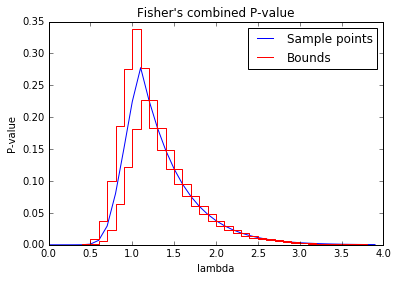

In [5]:
plt.plot(res['grid'], res['sample_points'], 'b-', label="Sample points")
lb = [0]+res['lower_bounds']
ub = [0]+res['upper_bounds']
plt.step(res['grid'], lb, 'r-', label="Bounds")
plt.step(res['grid'], ub, 'r-')
plt.xlabel("lambda")
plt.ylabel("P-value")
plt.title("Fisher's combined P-value")
plt.legend()
plt.show()